In [12]:
import lmfit
import xarray as xr
import pandas as pd
import numpy as np
import copy

import glob

import xrft
import finufft

from uncertainties import ufloat
from uncertainties import unumpy as unp
from uncertainties import umath

from datetime import datetime

import matplotlib.pyplot as plt

#test
plt.rcParams['font.size'] = 18

from scipy.ndimage import gaussian_filter
import matplotlib as mpl
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)

from DataContainer.ReadData import read_hdf5_file, read_hdf5_global, read_hdf5_run_time, read_csv_file
from Analyser.ImagingAnalyser import ImageAnalyser
from Analyser.FitAnalyser import FitAnalyser
from Analyser.FitAnalyser import ThomasFermi2dModel, DensityProfileBEC2dModel, Polylog22dModel
from Analyser.FFTAnalyser import fft, ifft, fft_nutou
from ToolFunction.ToolFunction import *

import time

from ToolFunction.HomeMadeXarrayFunction import errorbar, dataarray_plot_errorbar
xr.plot.dataarray_plot.errorbar = errorbar
xr.plot.accessor.DataArrayPlotAccessor.errorbar = dataarray_plot_errorbar

imageAnalyser = ImageAnalyser()



In [13]:
# get center of thresholded image
def calc_thresh(data, thresh_val=0.3, sigma=0.4):
    """Returns thresholded binary image after blurring to guess BEC size

    :param data: 2d image or 1D or 2D array containing 2d images
    :type data: 2d, 3d or 4d numpy array
    :param thresh_val: relative threshhold value for binarization with respect to maximum of blurred image
    :param sigma: sigma of gaussian blur filter (see scipy.ndimage.gaussian_filter
    :return: binary 2d image or 1D or 2D array containing 2d images
    :rtype: 2d, 3d or 4d numpy array
    """
    shape = np.shape(data)
    thresh = np.zeros(shape)

    blurred = gaussian_filter(data, sigma=sigma)

    if len(shape) == 4:
        for i in range(0,shape[0]):
            for j in range(0, shape[1]):
                thresh[i,j] = np.where(blurred[i,j] < np.max(blurred[i,j])*thresh_val, 0, 1)

    elif len(shape) == 3:
        for i in range(0,shape[0]):
                thresh[i] = np.where(blurred[i] < np.max(blurred[i])*thresh_val, 0, 1)

    elif len(shape) == 2:
        thresh = np.where(blurred < np.max(blurred)*thresh_val, 0, 1)


    else:
        print("Shape of data is wrong, output is empty")

    return thresh

def calc_cen(thresh1):
    """
    returns array: [X_center,Y_center]
    """
    cen = np.zeros(2)
    (Y,X) = np.shape(thresh1)


    thresh1 = thresh1 /np.sum(thresh1)

    # marginal distributions
    dx = np.sum(thresh1, 0)
    dy = np.sum(thresh1, 1)

    # expected values
    cen[0] = np.sum(dx * np.arange(X))
    cen[1] = np.sum(dy * np.arange(Y))
    return cen

def calc_cen_bulk(thresh):
    """
    returns array in shape of input, containing array with [Y_center,X_center] for each image
    """
    shape = np.shape(thresh)
    cen = np.zeros((shape[0], shape[1], 2))
    for i in range(0, shape[0]):
        for j in range(0, shape[1]):
            cen[i,j] = calc_cen(thresh[i,j])
    return cen

def guess_BEC_width(thresh, center):
    """
    returns width of thresholded area along both axis through the center with shape of thresh and [X_width, Y_width] for each image
    """
    shape = np.shape(thresh)

    if len(shape) == 2:
        BEC_width_guess = np.array([np.sum(thresh[round(center[1]), :]), np.sum(thresh[:, round(center[0])]) ])

    elif len(shape) == 3:
        BEC_width_guess = np.zeros((shape[0], 2))
        for i in range(0, shape[0]):
            BEC_width_guess[i, 0] = np.sum(thresh[i, round(center[i,j,1]), :])
            BEC_width_guess[i, 1] = np.sum(thresh[i, :, round(center[i,j,0])])

    elif len(shape) == 4:
        BEC_width_guess = np.zeros((shape[0], shape[1], 2))
        for i in range(0, shape[0]):
            for j in range(0, shape[1]):
                BEC_width_guess[i, j, 0] = np.sum(thresh[i, j, round(center[i,j,1]), :])
                BEC_width_guess[i, j, 1] = np.sum(thresh[i, j, :, round(center[i,j,0])])
    else:
        print("Shape of data is wrong, output is empty")

    return BEC_width_guess



def gaussian(x, x0, sigma, A):
    return A * np.exp(-0.5 * (x-x0)**2 / sigma**2)

# def polylog(power, numerator, order = 15):
#
#     dataShape = numerator.shape
#     numerator = np.tile(numerator, (order, 1))
#     numerator = np.power(numerator.T, np.arange(1, order+1)).T
#
#     denominator = np.arange(1, order+1)
#     denominator = np.tile(denominator, (dataShape[0], 1))
#     denominator = denominator.T
#
#     data = numerator/ np.power(denominator, power)
#
#     return np.sum(data, axis=0)

def polylog_tab(pow, x):
    order = 100
    sum = 0
    for k in range(1,order):
        sum  += x ** k /k **pow
    return sum

x_int = np.linspace(0, 1.00001, 100000)

poly_tab = polylog_tab(2,x_int)



polylog_int = CubicSpline(x_int, poly_tab)

def thermal(x, x0, amp, sigma):
    res = np.exp(-0.5 * (x-x0)**2 / sigma**2)
    return amp/1.643 * polylog_int(res)

def Thomas_Fermi_1d(x, x0, amp, sigma):
    res = (1- ((x-x0)/sigma)**2)
    res = np.where(res > 0, res, 0)
    res = res**(3/2)
    return amp * res

def density_1d(x, x0_bec, x0_th, amp_bec, amp_th, sigma_bec, sigma_th):
    return thermal(x, x0_th, amp_th, sigma_th) + Thomas_Fermi_1d(x, x0_bec, amp_bec, sigma_bec)


def polylog(pow, x):
    order = 15
    sum = 0
    for k in range(1,order):
        sum  += x ** k /k **pow
    return sum


def ThomasFermi_2d(x, y=0.0, centerx=0.0, centery=0.0, amplitude=1.0, sigmax=1.0, sigmay=1.0):

    res = (1- ((x-centerx)/(sigmax))**2 - ((y-centery)/(sigmay))**2)
    res = np.where(res > 0, res, 0)
    res = res**(3/2)
    return amplitude * res
    # return amplitude * 5 / 2 / np.pi / max(tiny, sigmax * sigmay) * np.where(res > 0, res, 0)


    # return amplitude / 2 / np.pi / 1.20206 / max(tiny, sigmax * sigmay) * polylog(2, np.exp( -((x-centerx)**2/(2 * (sigmax)**2))-((y-centery)**2/( 2 * (sigmay)**2)) ))
# Set up table for polylog


def polylog2_2d(x, y=0.0, centerx=0.0, centery=0.0, amplitude=1.0, sigmax=1.0, sigmay=1.0):
    ## Approximation of the polylog function with 2D gaussian as argument. -> discribes the thermal part of the cloud
    return amplitude/1.643  * polylog_int(np.exp( -((x-centerx)**2/(2 * sigmax**2))-((y-centery)**2/( 2 * sigmay**2)) ))



def density_profile_BEC_2d(x, y=0.0, amp_bec=1.0, amp_th=1.0, x0_bec=0.0, y0_bec=0.0, x0_th=0.0, y0_th=0.0,
                           sigmax_bec=1.0, sigmay_bec=1.0, sigma_th=1.0):
    return ThomasFermi_2d(x=x, y=y, centerx=x0_bec, centery=y0_bec,
                          amplitude=amp_bec, sigmax=sigmax_bec, sigmay=sigmay_bec
                          ) + polylog2_2d(x=x, y=y, centerx=x0_th, centery=y0_th,
                                          amplitude=amp_th, sigmax=sigma_th,sigmay=sigma_th)

def cond_frac(results):
    bval = results.best_values
    tf_fit = ThomasFermi_2d(X,Y,centerx=bval['x0_bec'], centery=bval['y0_bec'], amplitude=bval['amp_bec'], sigmax=bval['sigmax_bec'], sigmay=bval['sigmay_bec'])
    N_bec = np.sum(tf_fit)
    fit = fit = density_profile_BEC_2d(X,Y, **bval)
    N_ges = np.sum(fit)
    return N_bec/N_ges

def print_bval(res_s):
    keys = res_s.best_values.keys()
    bval = res_s.best_values
    init = res_s.init_params

    for item in keys:
        print(f'{item}: {bval[item]:.3f}, (init = {init[item].value:.3f}), bounds = [{init[item].min:.2f} : {init[item].max :.2f}] ')
    print('')

def print_bval_bulk(res_):
    shape = np.shape(res_)
    if len(shape) == 2:
        for i in range(shape[0]):
            for j in range(shape[1]):
                print(f'image: {i}, {j}')
                print_bval(res_[i][j])

    if len(shape) == 1:
        for i in range(shape[0]):
            print(f'image: {i}')
            print_bval(res_[i])


# model = DensityProfileBEC2dModel()
#
# init_params = model.guess(data, x, y)
#
# res = model.fit(data, x=x, y=y, params = init_params)
#
# if not res makes sense:
#     params update --> A_th = 0
#     res = model.fit


In [18]:
import lmfit



class DensityProfileBEC2dModel(lmfit.Model):

    def __init__(self, independent_vars=['x', 'y'], prefix='', nan_policy='raise',
                 **kwargs):
        kwargs.update({'prefix': prefix, 'nan_policy': nan_policy,
                       'independent_vars': independent_vars})
        super().__init__(density_profile_BEC_2d, **kwargs)
        self._set_paramhints_prefix()

    def _set_paramhints_prefix(self):
        # self.set_param_hint('BEC_sigmax', min=0)
        self.set_param_hint('amp_bec', min=0)
        self.set_param_hint('amp_th', min=0)
        self.set_param_hint('x0_bec', min=0)
        self.set_param_hint('y0_bec', min=0)
        self.set_param_hint('x0_th', min=0)
        self.set_param_hint('y0_th', min=0)
        self.set_param_hint('sigmax_bec', min=0)
        self.set_param_hint('sigmay_bec', min=0)
        self.set_param_hint('sigma_th', min=0)

    def guess(self, data, x, y, **kwargs):
        """Estimate initial model parameter values from data."""
        #
        # global X_guess
        # global bval_1d
        shape = np.shape(data)
        cut_width = np.max(shape)
        thresh = calc_thresh(data)
        center = calc_cen(thresh)

        BEC_width_guess = guess_BEC_width(thresh, center)

        X_guess = np.sum(data[round(center[1] - BEC_width_guess[1]/2) : round(center[1] + BEC_width_guess[1]/2) , :], 0) / len(data[round(center[1] - BEC_width_guess[1]/2) : round(center[1] + BEC_width_guess[1]/2),0])

        x = np.linspace(0, len(X_guess), len(X_guess))

        max_val = np.max(X_guess)

        # ToDo: check if image x and y dimension is right
        # ToDo: Fit along short axis not x
        fitmodel_1d = lmfit.Model(density_1d, independent_vars=['x'])
        params_1d = lmfit.Parameters()
        params_1d.add_many(
            ('x0_bec', center[0], True,0, 200),
            ('x0_th',center[0], True,0, 200),
            ('amp_bec', 0.7 * max_val, True, 0, 1.3 * max_val),
            ('amp_th', 0.3 * max_val, True, 0, 1.3 * max_val),
            ('deltax', 3*BEC_width_guess[0], True, 0,cut_width),
            # ('sigma_bec',BEC_width_guess[i,j,0]/1.22, True, 0, 50)
            ('sigma_bec',BEC_width_guess[0]/1.22, True, 0, 50)
        )
        params_1d.add('sigma_th', 3*BEC_width_guess[0], min=0, expr=f'0.632*sigma_bec + 0.518*deltax')

        res_1d = fitmodel_1d.fit(X_guess, x=x, params=params_1d)


        bval_1d = res_1d.best_values

        S = np.max(gaussian_filter(data, sigma=1)) / (bval_1d['amp_bec'] + bval_1d['amp_th'])
        max_val = np.max(data)

        params = self.make_params()

        if bval_1d['amp_th']/bval_1d['amp_bec'] > 3:
            print('Image seems to be purely thermal (guessed from 1d fit amplitude)')

            params[f'{self.prefix}amp_bec'].set(value=0, vary=False)
            params[f'{self.prefix}amp_th'].set(value= S * bval_1d['amp_th'], max= 1.3 * max_val, vary=True)
            params[f'{self.prefix}x0_bec'].set(value=1, vary=False)
            params[f'{self.prefix}y0_bec'].set(value=1, vary=False)
            params[f'{self.prefix}x0_th'].set(value=center[0], min=center[0] -10, max=center[0] + 10, vary=True)
            params[f'{self.prefix}y0_th'].set(value=center[1], min=center[1] -10, max=center[1] + 10, vary=True)
            params[f'{self.prefix}sigmax_bec'].set(value=1, vary=False)
            params[f'{self.prefix}sigmay_bec'].set(value=1, vary=False)
            params[f'{self.prefix}sigma_th'].set(value=bval_1d['sigma_th'], max=cut_width, vary=True)

        elif bval_1d['amp_bec']/bval_1d['amp_th'] > 10:
            print('Image seems to be pure BEC (guessed from 1d fit amplitude)')

            params[f'{self.prefix}amp_bec'].set(value= S * bval_1d['amp_bec'], max= 1.3 * max_val, vary=True)
            params[f'{self.prefix}amp_th'].set(value=0, vary=False)
            params[f'{self.prefix}x0_bec'].set(value=center[0], min=center[0] -10, max=center[0] + 10, vary=True)
            params[f'{self.prefix}y0_bec'].set(value=center[1], min=center[1] -10, max=center[1] + 10, vary=True)
            params[f'{self.prefix}x0_th'].set(value=1, vary=False)
            params[f'{self.prefix}y0_th'].set(value=1, vary=False)
            params[f'{self.prefix}sigmax_bec'].set(value=bval_1d['sigma_bec'], max= 2*BEC_width_guess[0], vary=True)
            params[f'{self.prefix}sigmay_bec'].set(value=BEC_width_guess[1]/1.22, max= 2*BEC_width_guess[1], vary=True)
            params[f'{self.prefix}sigma_th'].set(value=1, vary=False)

        else:
            params[f'{self.prefix}amp_bec'].set(value= S * bval_1d['amp_bec'], max= 1.3 * max_val, vary=True)
            params[f'{self.prefix}amp_th'].set(value= S * bval_1d['amp_th'], max= 1.3 * max_val, vary=True)
            params[f'{self.prefix}x0_bec'].set(value=center[0], min=center[0] -10, max=center[0] + 10, vary=True)
            params[f'{self.prefix}y0_bec'].set(value=center[1], min=center[1] -10, max=center[1] + 10, vary=True)
            params[f'{self.prefix}x0_th'].set(value=center[0], min=center[0] -10, max=center[0] + 10, vary=True)
            params[f'{self.prefix}y0_th'].set(value=center[1], min=center[1] -10, max=center[1] + 10, vary=True)
            params[f'{self.prefix}sigmax_bec'].set(value=bval_1d['sigma_bec'], max= 2*BEC_width_guess[0], vary=True)
            params[f'{self.prefix}sigmay_bec'].set(value=BEC_width_guess[1]/1.22, max= 2*BEC_width_guess[1], vary=True)
            params[f'{self.prefix}sigma_th'].set(value=bval_1d['sigma_th'], max=cut_width, vary=True)



        return lmfit.models.update_param_vals(params, self.prefix, **kwargs)


    def fit(self, data, imaging_props: dict[str, any] = {'magn' : 2.352, 'eff_pix' : 2.493e-6, 'eta' : 0.5, 'sig_cross' : 8.4743e-14}, **kwargs):
        expected_keys = {'magn', 'eff_pix', 'eta', 'sig_cross'}

        if not set(imaging_props.keys()) == expected_keys:
            raise ValueError(f"Invalid dictionary structure, expected keys: {expected_keys}")

        data1d = data.flatten()

        res = super().fit(data1d, **kwargs)

        # conversion N_count to Pixels
        F = 1 /imaging_props['eta'] /imaging_props['sigma_cross'] * imaging_props['eff_pix']**2 /imaging_props['magn']

        if res.params['amp_bec'].vary and res.params['amp_th'].vary:
            bval = res.best_values
            sigma_cut = max(bval['sigmay_bec'], bval['sigmax_bec'])
            tf_fit = ThomasFermi_2d(X,Y,centerx=bval['x0_bec'], centery=bval['y0_bec'], amplitude=bval['amp_bec'], sigmax=bval['sigmax_bec'], sigmay=bval['sigmay_bec'])
            tf_fit_2 = ThomasFermi_2d(X,Y,centerx=bval['x0_bec'], centery=bval['y0_bec'], amplitude=bval['amp_bec'], sigmax=1.5 * sigma_cut, sigmay=1.5*sigma_cut)

            mask = np.where(tf_fit > 0, np.nan, data)
            #mask[i,j] = gaussian_filter(mask[i,j], sigma = 0.4)
            mask = np.where(tf_fit_2 > 0, mask, np.nan)

            N_c = np.nansum(mask)
            # conversion N_count to Pixels
            N_a = F * N_c


            if N_a < 2806:
                print('No thermal part detected, performing fit without thermal function')
                params = res.params
                params[f'{self.prefix}amp_th'].set(value=0, vary=False)
                params[f'{self.prefix}x0_th'].set(value=1, vary=False)
                params[f'{self.prefix}y0_th'].set(value=1, vary=False)
                params[f'{self.prefix}sigma_th'].set(value=1, vary=False)

                res = super().fit(data1d, x=kwargs['x'], y=kwargs['y'], params=params)

                return res

        return res


In [54]:
imaging_props = {'magn' : 2.352, 'eff_pix' : 2.493e-6, 'eta' : 0.5, 'sigma_cross' : 8.4743e-14}

# conversion N_count to Pixels
F = 1 /imaging_props['eta'] /imaging_props['sigma_cross'] * imaging_props['eff_pix']**2 /imaging_props['magn']**2

# F = imaging_props['eff_pix']**2/imaging_props['sigma_cross']
print(F*45)

3300.298608734645


In [8]:
test_d = {'magn' : 1, 'eff_pix' : 7, 'sig_cross' : 10e-7}


test_func(test_d)

test_func()

Success


In [29]:
# load Brittas data

data = np.empty((2,11, 1200, 1920))
data[0] = np.load('Data_Britta/OD_ft_flatfield.npy')
data[1] = np.load('Data_Britta/OD_ft_manual.npy')

cut_width = 250
thresh = calc_thresh(data)
center = calc_cen_bulk(thresh)

shape = np.shape(data)
cropOD = np.zeros((shape[0], shape[1], cut_width, cut_width))

for i in range(0,shape[0]):
    for j in range(0, shape[1]):
        cropOD[i,j] = data[i,j, round(center[i,j,1]-cut_width/2):round(center[i,j,1]+cut_width/2), round(center[i,j,0]-cut_width/2):round(center[i,j,0]+cut_width/2)]

shape = np.shape(cropOD)

In [57]:
i = 1
j = 7
print(F *np.sum(cropOD[i,j]))
print(F*np.sum(data[i,j]))
print(np.min(data[i,j]))
print( np.unravel_index(np.argmin(data[i,j]),(1200,1920)) )

49415.86534245327
-inf
-inf
(1084, 483)


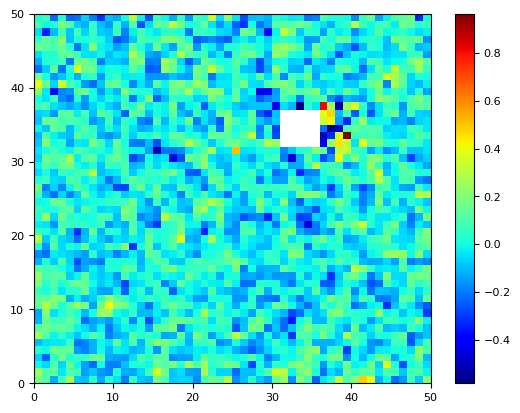

In [52]:
im = plt.pcolormesh(gaussian_filter(data[i,j,1050:1100, 450:500], sigma=0.5), cmap='jet')
plt.colorbar(im)
plt.show()

In [19]:
Fitmodel = DensityProfileBEC2dModel()

x = np.linspace(0,shape[3],cut_width)
y = np.linspace(0,shape[2], cut_width)

X,Y = np.meshgrid(x, y)
X_1d = X.flatten()
Y_1d = Y.flatten()
result = []
for i in range(0, shape[0]):
    t_res_arr = []
    for j in range(0, shape[1]):
        print(f'image: {i}, {j}')
        start = time.time()
        init = Fitmodel.guess(cropOD[i][j], X_1d, Y_1d)
        # init.pretty_print()
        res = Fitmodel.fit(cropOD[i][j], x=X_1d, y=Y_1d, params=init)
        stop = time.time()
        print(f'   time = {stop-start:.3f} s')
        t_res_arr.append(res)
    result.append((t_res_arr))



image: 0, 0
Image seems to be purely thermal (guessed from 1d fit amplitude)
{'magn': 2.352, 'eff_pix': 2.493e-06, 'sig_cross': 8.4743e-14}
   time = 0.252 s
image: 0, 1
{'magn': 2.352, 'eff_pix': 2.493e-06, 'sig_cross': 8.4743e-14}
   time = 0.410 s
image: 0, 2
{'magn': 2.352, 'eff_pix': 2.493e-06, 'sig_cross': 8.4743e-14}
   time = 0.342 s
image: 0, 3
{'magn': 2.352, 'eff_pix': 2.493e-06, 'sig_cross': 8.4743e-14}
   time = 0.381 s
image: 0, 4
{'magn': 2.352, 'eff_pix': 2.493e-06, 'sig_cross': 8.4743e-14}
   time = 0.233 s
image: 0, 5
{'magn': 2.352, 'eff_pix': 2.493e-06, 'sig_cross': 8.4743e-14}
   time = 0.397 s
image: 0, 6
{'magn': 2.352, 'eff_pix': 2.493e-06, 'sig_cross': 8.4743e-14}
   time = 0.351 s
image: 0, 7
{'magn': 2.352, 'eff_pix': 2.493e-06, 'sig_cross': 8.4743e-14}
No thermal part detected, performing fit without thermal function
   time = 0.478 s
image: 0, 8
{'magn': 2.352, 'eff_pix': 2.493e-06, 'sig_cross': 8.4743e-14}
No thermal part detected, performing fit without t

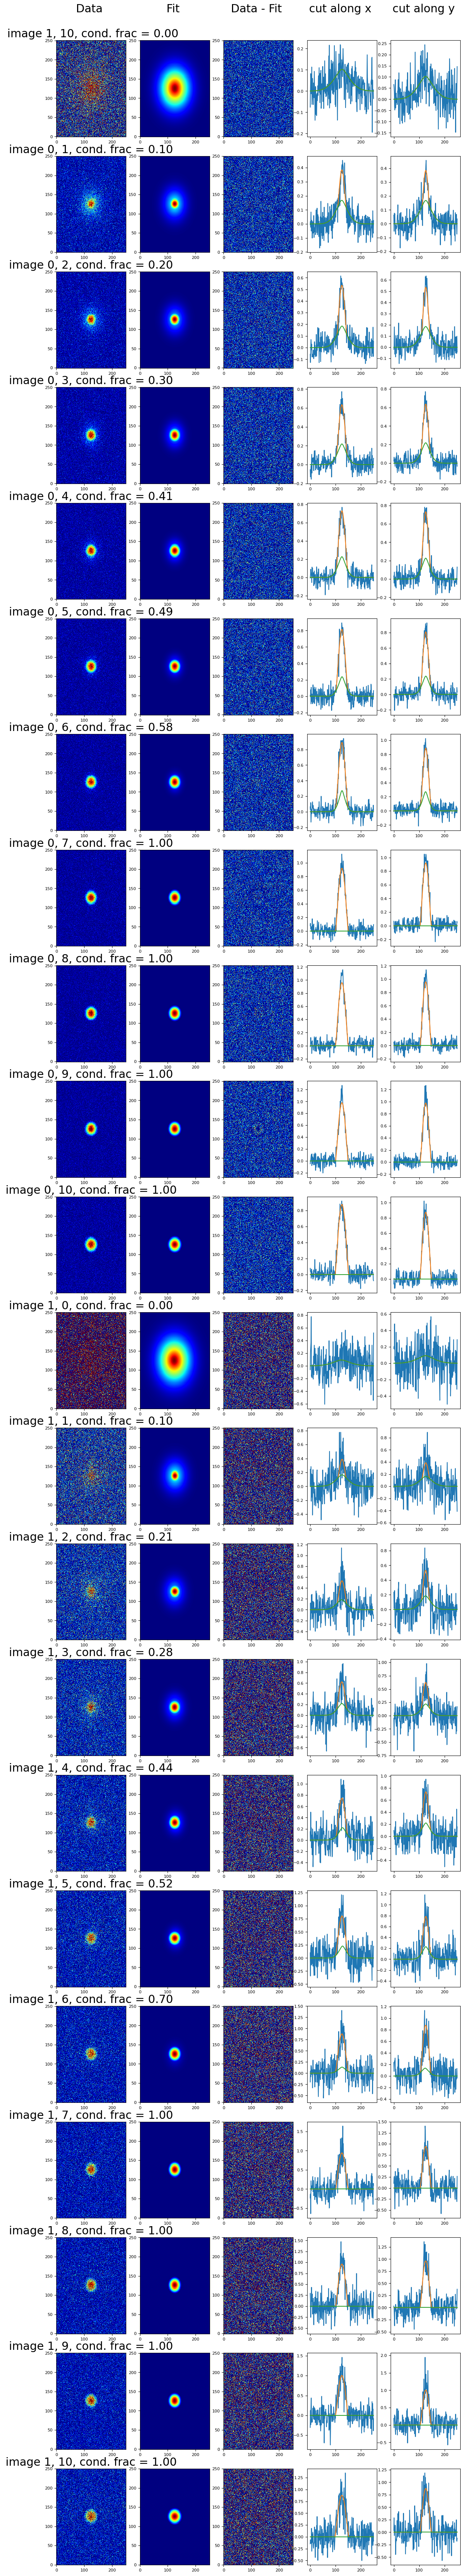

In [201]:
fig, axs = plt.subplots(shape[0] * shape[1], 5, figsize=(14, 4 * shape[0] * shape[1]),dpi = 100)

ii = 0
for i in range(0,shape[0]):

    for j in range(0,shape[1]):
        axs[ii,0].set_title(f'image {i}, {j}, cond. frac = {cond_frac(result[i][j]) :.2f}')
        lmfit.fit_report(result[i][j])
        bval = result[i][j].best_values
        fit = density_profile_BEC_2d(X,Y, **bval)
        vmax = np.max(fit)

        cen_x = round(max(bval['x0_th'], bval['x0_bec']))
        cen_y = round(max(bval['y0_th'], bval['y0_bec']))

        ax = axs[ii,0]
        ax.pcolormesh(X, Y, cropOD[i,j], vmin=0, vmax=vmax, cmap='jet', shading='auto')
        #plt.colorbar(art, ax=ax, label='z')


        # Plot gaussian 2d Fit + legend including Width parameters
        ax = axs[ii,1]

        ax.pcolormesh(X, Y, fit, vmin=0, vmax=vmax, cmap='jet', shading='auto')
        #plt.colorbar(art, ax=ax, label='z')

        ax = axs[ii,2]

        ax.pcolormesh(X, Y, fit-cropOD[i,j], vmin=0, vmax=0.2, cmap='jet', shading='auto')


        ax = axs[ii,3]

        ax.plot(x, cropOD[i,j, cen_y, :])
        ax.plot(x, fit[cen_y, :])
        ax.plot(x, thermal(x, bval['x0_th'], bval['amp_th'], bval['sigma_th']))

        ax = axs[ii,4]

        ax.plot(y, cropOD[i,j, :, cen_x])
        ax.plot(y, fit[:, cen_x])
        ax.plot(x, thermal(y, bval['y0_th'], bval['amp_th'], bval['sigma_th']))


        ii += 1

axs[0,0].set_title(f'Data \n \n image {i}, {j}, cond. frac = {cond_frac(result[0][0]) :.2f}')
axs[0,1].set_title('Fit \n \n')
axs[0,2].set_title('Data - Fit \n \n')
axs[0,3].set_title('cut along x \n \n')
axs[0,4].set_title('cut along y \n \n')



plt.show()


image: 0, 0
Image seems to be purely thermal (guessed from 1d fit amplitude)
{'x0_bec': 141.9388495930993, 'x0_th': 124.26348801310331, 'amp_bec': 0.007803691687802039, 'amp_th': 0.0858750681615077, 'sigma_bec': 46.86928315350596, 'sigma_th': 39.30783070539829}


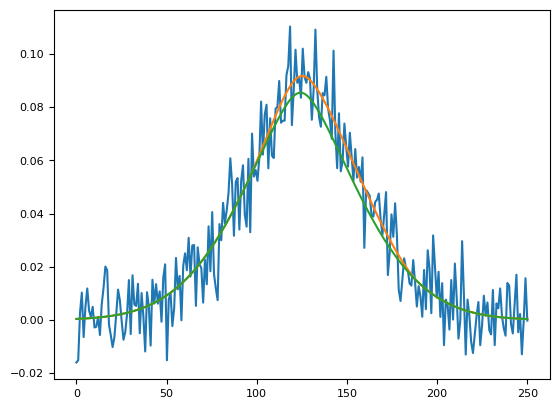

image: 0, 1
{'x0_bec': 125.38163142125995, 'x0_th': 124.49885958144816, 'amp_bec': 0.12141877271402701, 'amp_th': 0.15821401051357287, 'sigma_bec': 15.843973367955948, 'sigma_th': 28.209064417127983}


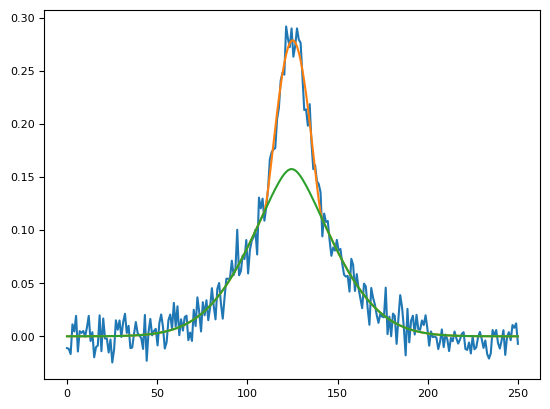

image: 0, 2
{'x0_bec': 125.062939389457, 'x0_th': 124.90856747839467, 'amp_bec': 0.19969242281440205, 'amp_th': 0.16311134280165113, 'sigma_bec': 18.298255963211897, 'sigma_th': 27.040711199511588}


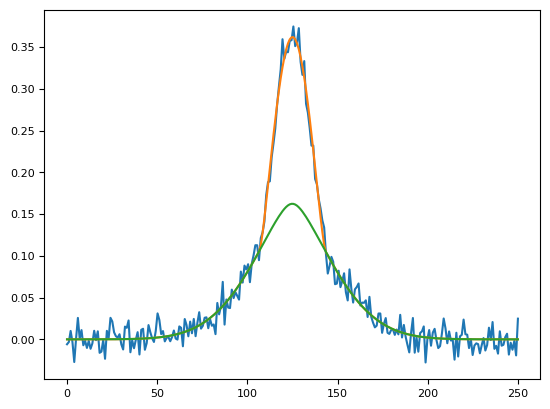

image: 0, 3
{'x0_bec': 124.93716396139996, 'x0_th': 125.00497547044476, 'amp_bec': 0.2683546088669588, 'amp_th': 0.20692658648004425, 'sigma_bec': 19.59891280345783, 'sigma_th': 21.4931782316055}


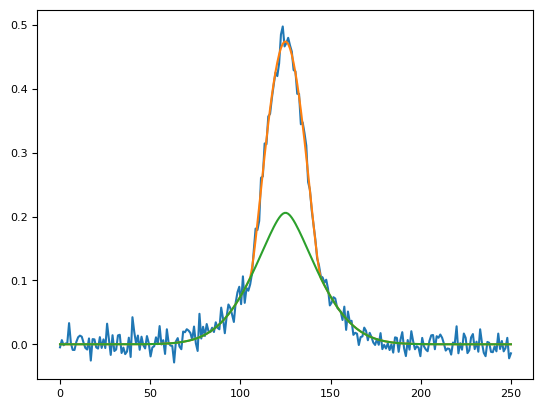

image: 0, 4
{'x0_bec': 125.11874376585588, 'x0_th': 125.14617962680515, 'amp_bec': 0.3772186215371362, 'amp_th': 0.20019282028651214, 'sigma_bec': 21.023211358748846, 'sigma_th': 20.353545926805133}


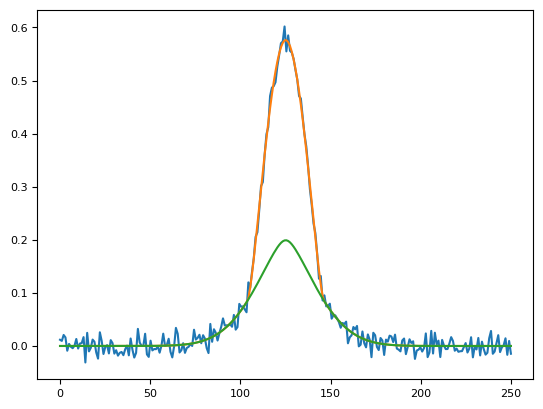

image: 0, 5
{'x0_bec': 125.02653078661412, 'x0_th': 125.17486768691222, 'amp_bec': 0.36938295522800974, 'amp_th': 0.2436025582693044, 'sigma_bec': 21.70321615610075, 'sigma_th': 17.165663035342554}


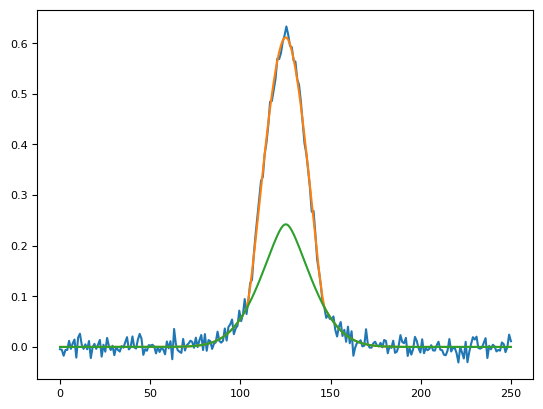

image: 0, 6
{'x0_bec': 124.89822161181937, 'x0_th': 125.37729750375459, 'amp_bec': 0.46158795707906725, 'amp_th': 0.21923439478678494, 'sigma_bec': 22.939154769975083, 'sigma_th': 16.138144354700508}


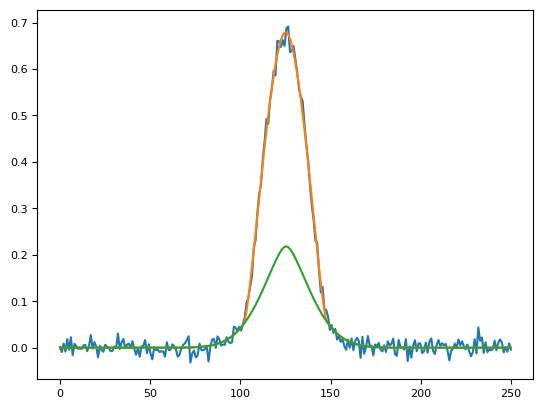

image: 0, 7
{'x0_bec': 125.03279653115828, 'x0_th': 124.84110050371334, 'amp_bec': 0.5627533395292672, 'amp_th': 0.16180945390692278, 'sigma_bec': 23.249266183667334, 'sigma_th': 14.69353622979438}


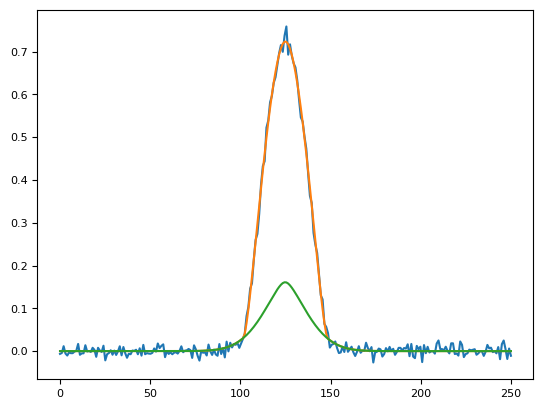

image: 0, 8
{'x0_bec': 125.00429964824527, 'x0_th': 125.04731652051468, 'amp_bec': 0.6062908065559611, 'amp_th': 0.15812192425042074, 'sigma_bec': 23.410202515558918, 'sigma_th': 14.795247990074596}


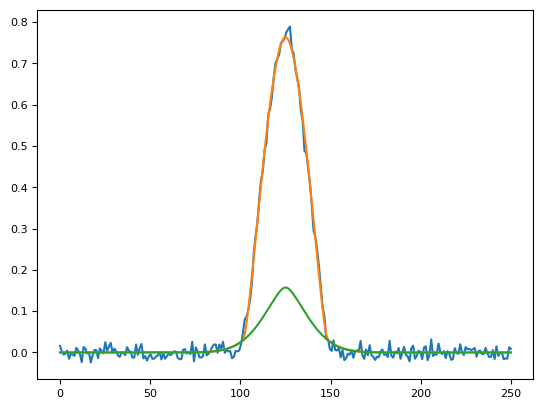

image: 0, 9
{'x0_bec': 125.03656964618455, 'x0_th': 124.76187778970447, 'amp_bec': 0.5769223246245394, 'amp_th': 0.2327501634748024, 'sigma_bec': 23.160544703046963, 'sigma_th': 14.637464253443392}


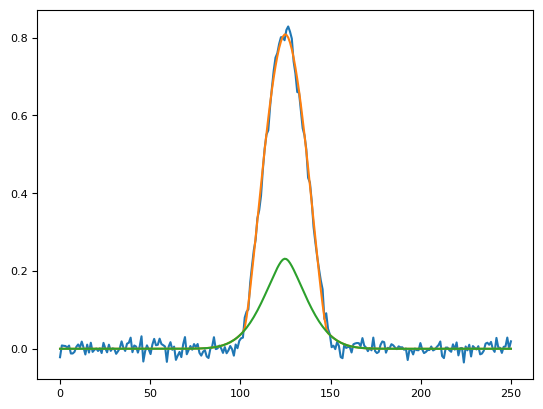

image: 0, 10
Image seems to be pure BEC (guessed from 1d fit amplitude)
{'x0_bec': 125.17664256918006, 'x0_th': 0.08189463384382645, 'amp_bec': 0.6670109105975315, 'amp_th': 0.0012688907842482594, 'sigma_bec': 25.27841271967096, 'sigma_th': 66.64693647236199}


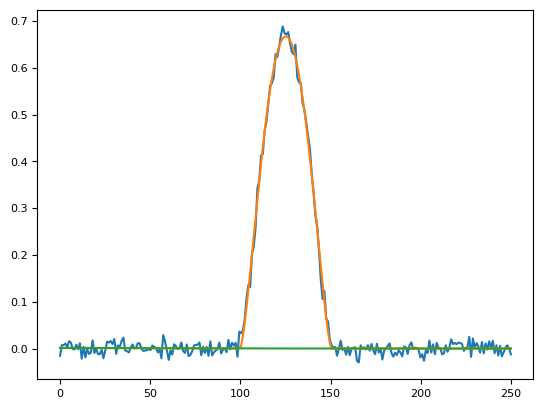

image: 1, 0
{'x0_bec': 115.13147723692292, 'x0_th': 125.05103983194897, 'amp_bec': 0.02112511198925298, 'amp_th': 0.07395402501713118, 'sigma_bec': 15.723788570332712, 'sigma_th': 48.1198044449804}


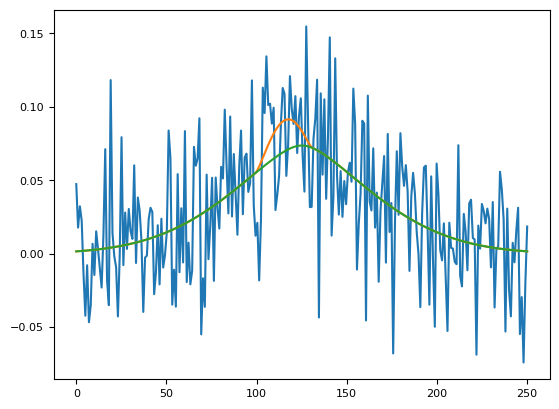

image: 1, 1
{'x0_bec': 125.98266418134926, 'x0_th': 125.10607266718432, 'amp_bec': 0.15076792988288587, 'amp_th': 0.14032268056966216, 'sigma_bec': 15.58363774828232, 'sigma_th': 32.91110196057714}


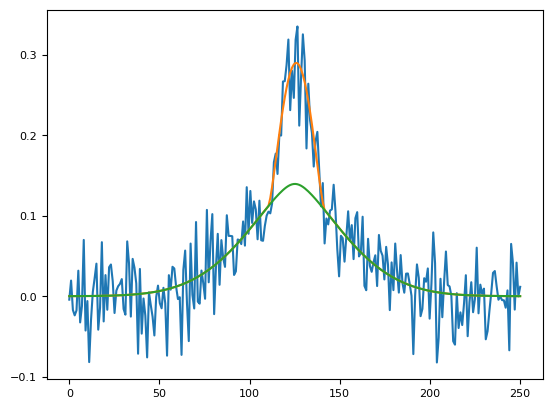

image: 1, 2
{'x0_bec': 126.1172887092211, 'x0_th': 121.91922044593235, 'amp_bec': 0.22750238845860385, 'amp_th': 0.17565334199821572, 'sigma_bec': 18.273136515366595, 'sigma_th': 23.539294758943058}


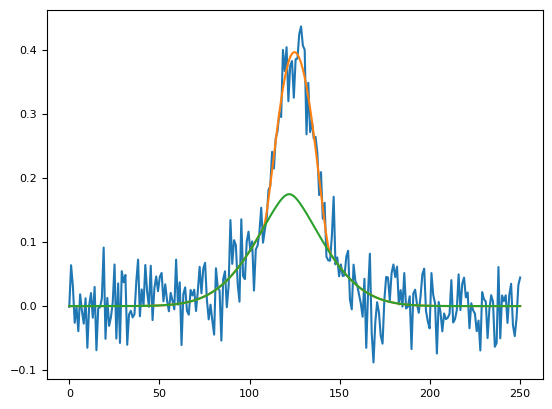

image: 1, 3
{'x0_bec': 124.54686569481797, 'x0_th': 125.30784821887502, 'amp_bec': 0.3198846898793186, 'amp_th': 0.22188704166381057, 'sigma_bec': 20.01394955278246, 'sigma_th': 22.416678235965882}


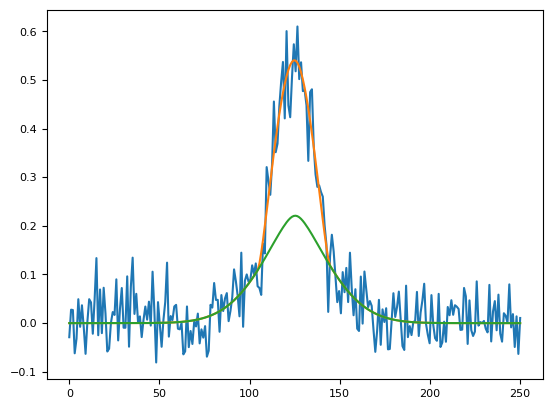

image: 1, 4
{'x0_bec': 124.94088540695563, 'x0_th': 126.05838860646763, 'amp_bec': 0.4854770484380169, 'amp_th': 0.10120909270389601, 'sigma_bec': 21.984988170628352, 'sigma_th': 29.08919919364982}


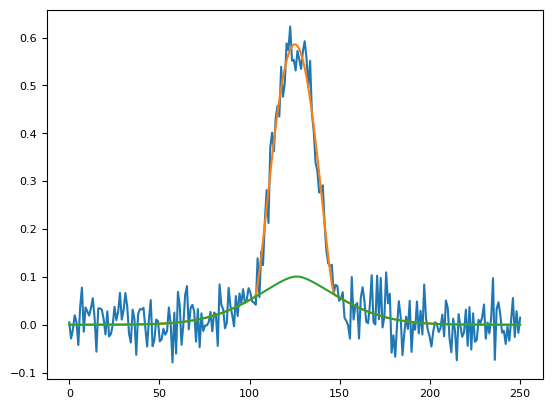

image: 1, 5
{'x0_bec': 124.13202436253795, 'x0_th': 127.1284100236026, 'amp_bec': 0.3692513342418664, 'amp_th': 0.25168044523752053, 'sigma_bec': 22.086974645622263, 'sigma_th': 17.83800603647807}


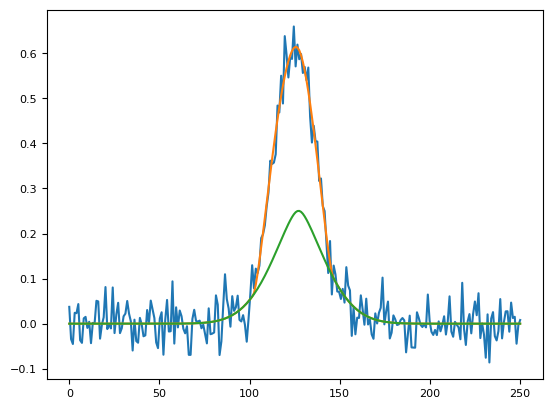

image: 1, 6
{'x0_bec': 124.03965908195778, 'x0_th': 127.34721368748414, 'amp_bec': 0.4855471995353272, 'amp_th': 0.2562779233501634, 'sigma_bec': 23.62210984602798, 'sigma_th': 14.929173432250373}


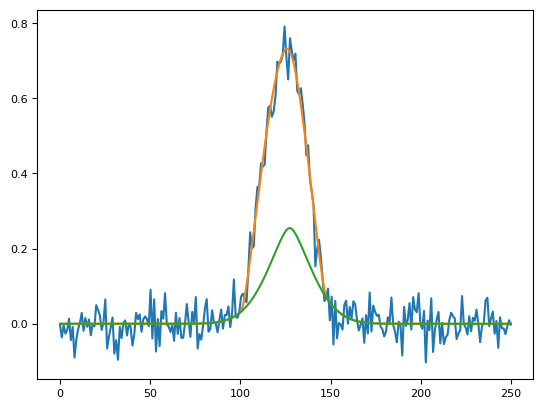

image: 1, 7
{'x0_bec': 124.3102516408376, 'x0_th': 129.41550511341939, 'amp_bec': 0.6796952456245661, 'amp_th': 0.1804669142499331, 'sigma_bec': 23.20386857434493, 'sigma_th': 14.664844940958337}


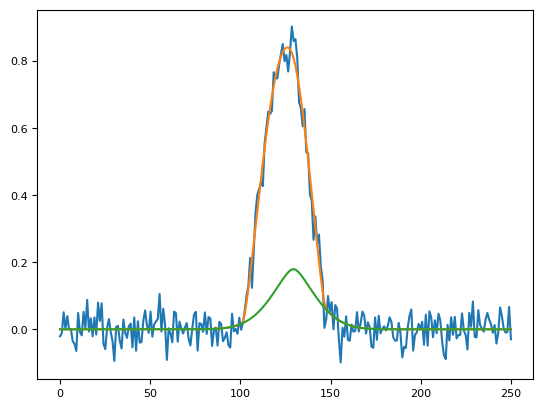

image: 1, 8
{'x0_bec': 125.61877194001123, 'x0_th': 123.4006658543455, 'amp_bec': 0.6593565560433862, 'amp_th': 0.2342058441345835, 'sigma_bec': 23.13540932172452, 'sigma_th': 14.621578817427519}


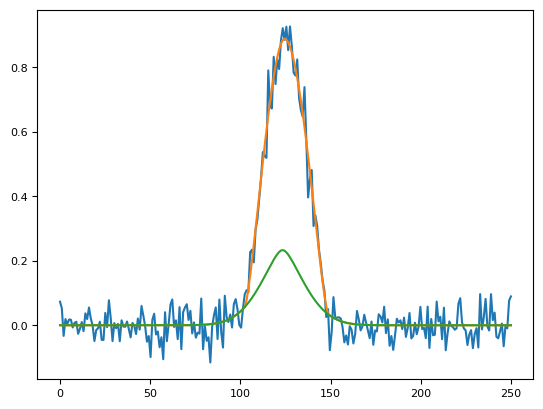

image: 1, 9
Image seems to be pure BEC (guessed from 1d fit amplitude)
{'x0_bec': 124.67090198215693, 'x0_th': 152.27820518157057, 'amp_bec': 0.8178652575015817, 'amp_th': 0.026889421982387324, 'sigma_bec': 23.48422463948881, 'sigma_th': 22.56373662024177}


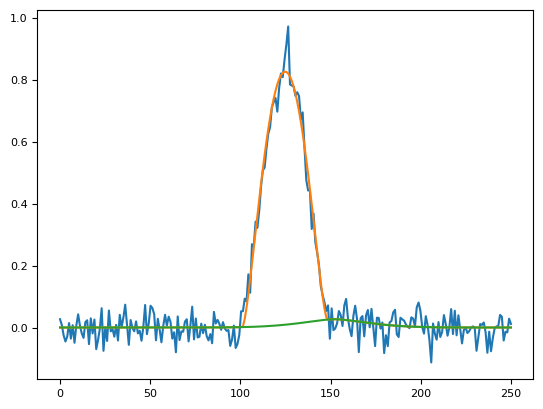

image: 1, 10
Image seems to be pure BEC (guessed from 1d fit amplitude)
{'x0_bec': 124.90950013701135, 'x0_th': 52.01141356926877, 'amp_bec': 0.751254779373083, 'amp_th': 0.009191897095241318, 'sigma_bec': 26.370801991139352, 'sigma_th': 16.666346903716047}


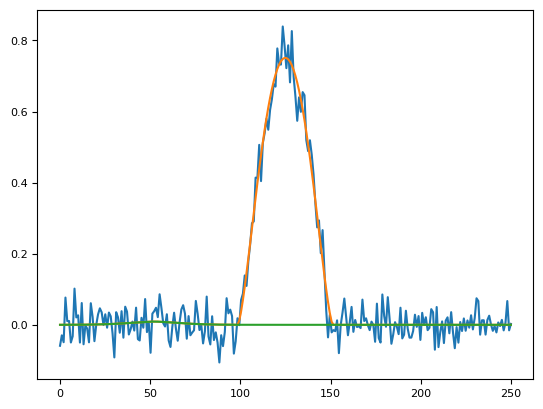

In [157]:
for i in range(0, shape[0]):
    for j in range(0, shape[1]):
        print(f'image: {i}, {j}')
        init = Fitmodel.guess(cropOD[i][j], X_1d, Y_1d)
        # init.pretty_print()
        print(bval_1d)
        plt.plot(x, X_guess)
        plt.plot(x, density_1d(x, **bval_1d))
        plt.plot(x, thermal(x, bval_1d['x0_th'], bval_1d['amp_th'], bval_1d['sigma_th']))
        plt.show()


In [190]:
result[0][0].params['amp_bec'].vary

False